# Hackaton La Rondelle

In [17]:
import xarray as xr
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

In [18]:
eddies_train = xr.open_dataset("data/eddies_train.nc")
OSSE_train = xr.open_dataset("data/OSSE_U_V_SLA_SST_train.nc")

In [19]:
# path_eddies_train = "/kaggle/input/ocean-eddy-detection-2025/eddies_train.nc"
# eddies_train = xr.open_dataset(path_eddies_train)

# path_OSSE_train = "/kaggle/input/ocean-eddy-detection-2025/OSSE_U_V_SLA_SST_train.nc"
# OSSE_train = xr.open_dataset(path_OSSE_train)

In [20]:
# Remplacer les valeurs de "nan", "NaN", "NAN" par np.nan
eddies_train["eddies"] = eddies_train["eddies"].where(~eddies_train["eddies"].isin(["nan", "NaN", "NAN", "NaN "]), np.nan)

# Vérifier le nombre de NaN avant modification
print("Nombre de NaN avant :", np.isnan(eddies_train["eddies"]).sum().values)

Nombre de NaN avant : 23685032


In [21]:
# Remplacer les NaN par 999
eddies_train["eddies"] = eddies_train["eddies"].fillna(999)

# Vérifier qu'il n'y a plus de NaN
print("Nombre de NaN après :", np.isnan(eddies_train["eddies"]).sum().values)

Nombre de NaN après : 0


In [22]:
# Vérifier et remplacer les occurrences de "nan", "NaN", "NAN", "NaN " par np.nan dans chaque variable
for var in OSSE_train.data_vars:
    # Remplacer les valeurs de "nan", "NaN", "NAN", "NaN " par np.nan
    OSSE_train[var] = OSSE_train[var].where(~OSSE_train[var].isin(["nan", "NaN", "NAN", "NaN "]), np.nan)
    
    # Vérifier le nombre de NaN dans chaque variable avant modification
    print(f"Nombre de NaN dans {var} avant :", np.isnan(OSSE_train[var]).sum().values)

# Remplacer les NaN par 999 pour chaque variable
for var in OSSE_train.data_vars:
    OSSE_train[var] = OSSE_train[var].fillna(0)

# Vérifier qu'il n'y a plus de NaN
for var in OSSE_train.data_vars:
    print(f"Nombre de NaN dans {var} après :", np.isnan(OSSE_train[var]).sum().values)


Nombre de NaN dans vomecrtyT avant : 24555776
Nombre de NaN dans vozocrtxT avant : 24555776
Nombre de NaN dans sossheig avant : 23685032
Nombre de NaN dans votemper avant : 23685032
Nombre de NaN dans vomecrtyT après : 0
Nombre de NaN dans vozocrtxT après : 0
Nombre de NaN dans sossheig après : 0
Nombre de NaN dans votemper après : 0


In [23]:
# Renommer `time_counter` en `time`
OSSE_train = OSSE_train.rename({"time_counter": "time"})

# Supprimer l'ancienne dimension `time_counter` si elle est encore présente
if "time_counter" in OSSE_train.coords:
    OSSE_train = OSSE_train.drop_vars("time_counter")

# Fusionner les datasets
merged_ds = xr.merge([eddies_train, OSSE_train])
merged_ds


<xarray.Dataset> Size: 2GB
Dimensions:    (time: 284, latitude: 357, longitude: 717)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2015-01-02T12:00:00 ... 2015-12-25T1...
  * latitude   (latitude) float32 1kB -1.084e-19 2.967 0.0 ... 3.099 0.0
  * longitude  (longitude) float32 3kB 3.689e+19 -3.352 0.0 ... -3.221 0.0
    deptht     float32 4B 0.494
Data variables:
    eddies     (time, latitude, longitude) float64 582MB 999.0 999.0 ... 0.0 0.0
    vomecrtyT  (time, latitude, longitude) float32 291MB 0.0 0.0 ... 0.2156
    vozocrtxT  (time, latitude, longitude) float32 291MB 0.0 0.0 ... 0.03859
    sossheig   (time, latitude, longitude) float32 291MB 0.0 0.0 ... -0.8229
    votemper   (time, latitude, longitude) float32 291MB 0.0 0.0 ... 8.276 8.354
Attributes:
    history:  Thu Feb 23 10:17:59 2023: ncks -C -v eddies U_V_SLA_Eddies_2015...
    NCO:      4.4.7

In [24]:
# Remplacer les occurrences de chaînes 'nan', 'NaN', 'NAN' par np.nan
merged_ds = merged_ds.apply(lambda x: x.where(~x.isin(['nan', 'NaN', 'NAN']), np.nan))

# Remplacer toutes les occurrences de NaN (y compris celles qui sont des np.nan maintenant) par 0
merged_ds = merged_ds.fillna(0)

# Vérifier le nombre de NaN dans chaque variable après modification
for var in merged_ds.data_vars:
    print(f"Nombre de NaN dans {var} après remplacement :", np.isnan(merged_ds[var]).sum().values)

Nombre de NaN dans eddies après remplacement : 0
Nombre de NaN dans vomecrtyT après remplacement : 0
Nombre de NaN dans vozocrtxT après remplacement : 0
Nombre de NaN dans sossheig après remplacement : 0
Nombre de NaN dans votemper après remplacement : 0


In [25]:
from sklearn.preprocessing import MinMaxScaler

vars_to_normalize = ["vomecrtyT", "vozocrtxT", "sossheig", "votemper"]

def min_max_scale(da):
    scaler = MinMaxScaler()
    flat_data = da.values.reshape(-1, 1)
    scaled = scaler.fit_transform(flat_data).reshape(da.shape)
    return xr.DataArray(scaled, coords=da.coords, dims=da.dims, attrs=da.attrs)

normalized_ds = merged_ds.copy()
for var in vars_to_normalize:
    normalized_ds[var] = min_max_scale(merged_ds[var])


print(normalized_ds)

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 284, latitude: 357, longitude: 717)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2015-01-02T12:00:00 ... 2015-12-25T1...
  * latitude   (latitude) float32 1kB -1.084e-19 2.967 0.0 ... 3.099 0.0
  * longitude  (longitude) float32 3kB 3.689e+19 -3.352 0.0 ... -3.221 0.0
    deptht     float32 4B 0.494
Data variables:
    eddies     (time, latitude, longitude) float64 582MB 999.0 999.0 ... 0.0 0.0
    vomecrtyT  (time, latitude, longitude) float32 291MB 0.5162 ... 0.5587
    vozocrtxT  (time, latitude, longitude) float32 291MB 0.4055 ... 0.4137
    sossheig   (time, latitude, longitude) float32 291MB 0.4632 ... 0.1708
    votemper   (time, latitude, longitude) float32 291MB 0.06519 ... 0.2978


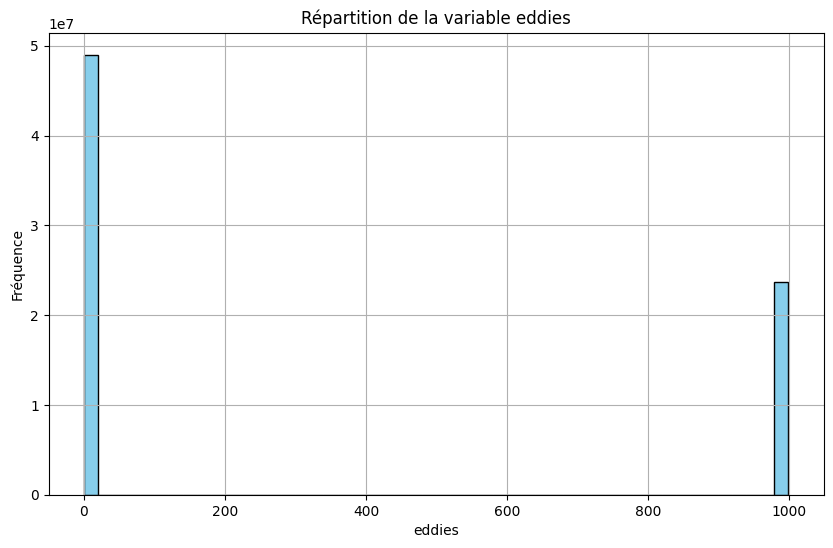

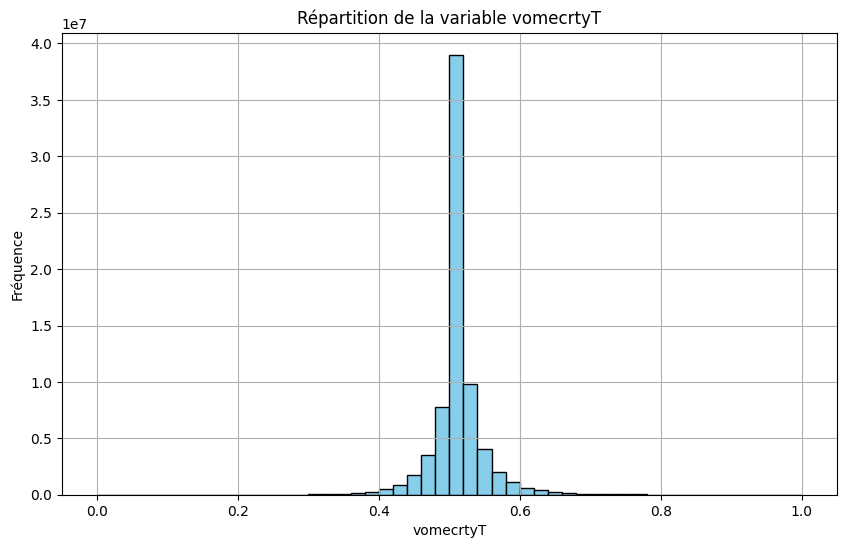

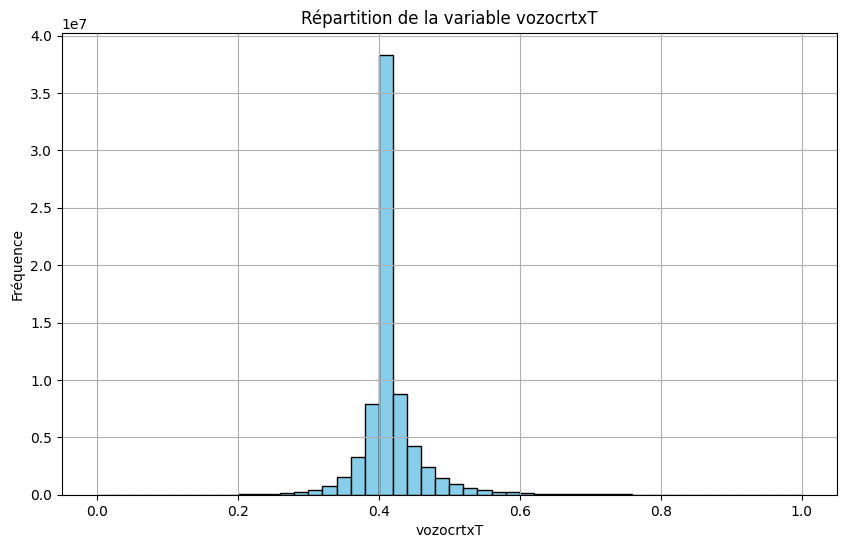

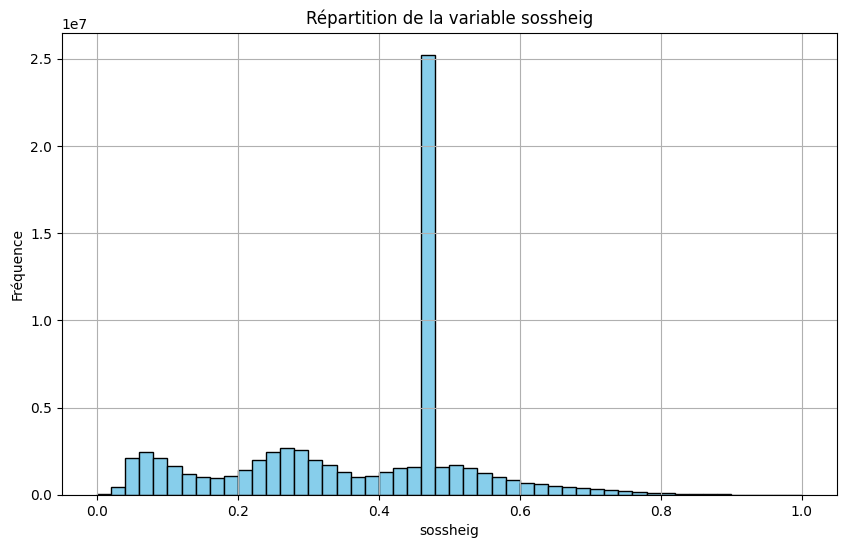

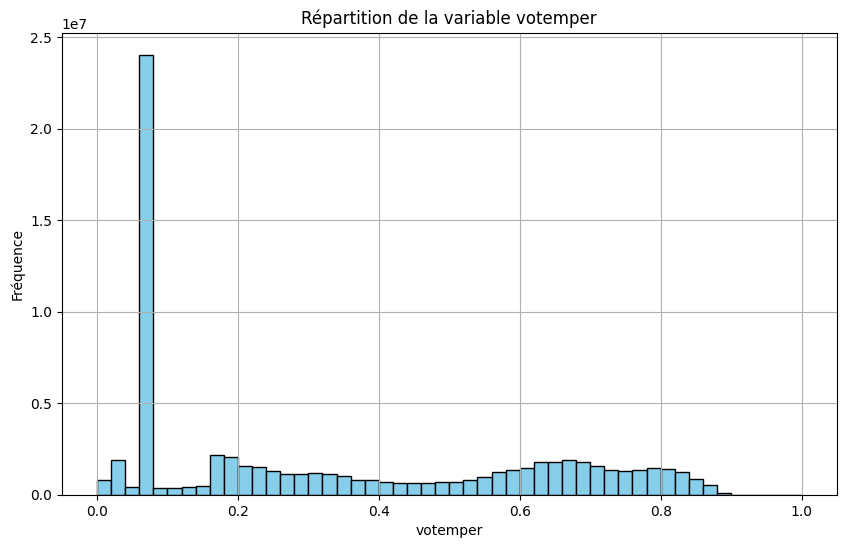

In [26]:
from matplotlib import pyplot as plt

# Liste des variables dans merged_ds
variables = list(normalized_ds.data_vars)

# Créer un histogramme pour chaque variable
for var in variables:
    data = normalized_ds[var].values.flatten()  # Convertir en array 1D
    # Suppression des NaN si présents
    data = data[~np.isnan(data)]
    
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=50, color='skyblue', edgecolor='black')
    plt.title(f"Répartition de la variable {var}")
    plt.xlabel(f"{var}")
    plt.ylabel("Fréquence")
    plt.grid(True)
    plt.show()


## II - Réseau de neurone

In [37]:
import torch
import xarray as xr
from torch.utils.data import DataLoader, random_split
import torch.nn as nn

ds = normalized_ds
# Définition de la classe OsseDataset
class OsseDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return self.data.dims["time"]

    def __getitem__(self, idx):
        U = self.data.vozocrtxT.values[idx, :, :]      
        V = self.data.vomecrtyT.values[idx, :, :]       
        sossheig = self.data.sossheig.values[idx, :, :]  
        votemper = self.data.votemper.values[idx, :, :]  
        eddies = self.data.eddies.values[idx, :, :]      

        inputs = {
            'U': torch.tensor(U, dtype=torch.float32),
            'V': torch.tensor(V, dtype=torch.float32),
            'sossheig': torch.tensor(sossheig, dtype=torch.float32),
            'votemper': torch.tensor(votemper, dtype=torch.float32)
        }
        targets = torch.tensor(eddies, dtype=torch.float32)

        if self.transform:
            sample = {'inputs': inputs, 'targets': targets}
            sample = self.transform(sample)
            return sample['inputs'], sample['targets']

        return inputs, targets

# Création de l'instance du dataset
dataset = OsseDataset(ds, transform=None)

# Division en ensembles d'entraînement et de validation (80%/20%)
total_samples = len(dataset)
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

b_size = 32

# Création des DataLoader pour l'entraînement et la validation
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=b_size, shuffle=False)


/var/folders/m3/k2rlmgps1yg0xlxmdh61l9pw0000gn/T/ipykernel_88971/2503643541.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.data.dims["time"]


In [38]:
for inputs, targets in train_loader:
    print("Inputs:", inputs)
    print("Targets:", targets)
    print("Inputs U shape:", inputs['U'].shape)
    print("Targets shape:", targets.shape)
    break

Inputs: {'U': tensor([[[0.4055, 0.4055, 0.4055,  ..., 0.3576, 0.3634, 0.3729],
         [0.4055, 0.4055, 0.4055,  ..., 0.3703, 0.3672, 0.3684],
         [0.4055, 0.4055, 0.4055,  ..., 0.3889, 0.3859, 0.3810],
         ...,
         [0.4073, 0.4073, 0.4071,  ..., 0.4377, 0.4378, 0.4350],
         [0.4074, 0.4075, 0.4075,  ..., 0.4357, 0.4350, 0.4342],
         [0.4071, 0.4073, 0.4075,  ..., 0.4439, 0.4475, 0.4497]],

        [[0.4055, 0.4055, 0.4055,  ..., 0.4037, 0.4122, 0.4193],
         [0.4055, 0.4055, 0.4055,  ..., 0.3986, 0.4056, 0.4096],
         [0.4055, 0.4055, 0.4055,  ..., 0.3883, 0.3892, 0.3851],
         ...,
         [0.4042, 0.4046, 0.4048,  ..., 0.4244, 0.4233, 0.4230],
         [0.4038, 0.4042, 0.4046,  ..., 0.4374, 0.4370, 0.4352],
         [0.4034, 0.4038, 0.4042,  ..., 0.4574, 0.4590, 0.4563]],

        [[0.4055, 0.4055, 0.4055,  ..., 0.3438, 0.3473, 0.3508],
         [0.4055, 0.4055, 0.4055,  ..., 0.3335, 0.3365, 0.3400],
         [0.4055, 0.4055, 0.4055,  ..., 0.32

In [39]:
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(4, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.center = self.conv_block(512, 1024)
        self.dec4 = self.conv_block(1024 + 512, 512)
        self.dec3 = self.conv_block(512 + 256, 256)
        self.dec2 = self.conv_block(256 + 128, 128)
        self.dec1 = self.conv_block(128 + 64, 64)
        self.final = nn.Conv2d(64, 1, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        center = self.center(F.max_pool2d(enc4, 2))
        
        # Spécifier la taille exacte pour l'interpolation
        up_center = F.interpolate(center, size=enc4.shape[-2:], mode='bilinear', align_corners=True)
        dec4 = self.dec4(torch.cat([up_center, enc4], dim=1))
        
        up_dec4 = F.interpolate(dec4, size=enc3.shape[-2:], mode='bilinear', align_corners=True)
        dec3 = self.dec3(torch.cat([up_dec4, enc3], dim=1))
        
        up_dec3 = F.interpolate(dec3, size=enc2.shape[-2:], mode='bilinear', align_corners=True)
        dec2 = self.dec2(torch.cat([up_dec3, enc2], dim=1))
        
        up_dec2 = F.interpolate(dec2, size=enc1.shape[-2:], mode='bilinear', align_corners=True)
        dec1 = self.dec1(torch.cat([up_dec2, enc1], dim=1))
        
        final = self.final(dec1)
        return final


In [40]:
class EddyPredictor(nn.Module):
    def __init__(self):
        super(EddyPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 128),  # 4 variables en entrée
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # 1 sortie (eddies)
        )

    def forward(self, x):
        return self.model(x)

In [41]:
class EddyPredictorCNN(nn.Module):
    def __init__(self):
        super(EddyPredictorCNN, self).__init__()
        # Ici on attend une entrée avec 4 canaux, et on souhaite une sortie avec 1 canal de même taille (pour la régression par pixel)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1)  # Renvoie une carte de sortie d'un canal
        )

    def forward(self, x):
        return self.conv_layers(x)

import torch

# Vérifier la disponibilité du backend MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Device utilisé :", device)

# Initialisation du modèle
model = EddyPredictorCNN().to(device)  # n'oubliez pas d'envoyer le modèle sur le GPU si nécessaire


Device utilisé : mps


In [51]:
criterion = nn.CrossEntropyLoss()

def validation(net):
    net.eval()
    valid_loss = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data

            # Si inputs est un dictionnaire, transfert sur GPU
            if isinstance(inputs, dict):
                inputs = {key: value.to(device) for key, value in inputs.items()}
                
                # Extraction des variables
                U = inputs['U']         # (B, H, W)
                V = inputs['V']         # (B, H, W)
                sossheig = inputs['sossheig']
                votemper = inputs['votemper']
                
                # Concaténation des canaux (B, 4, H, W)
                inputs_tensor = torch.stack([U, V, sossheig, votemper], dim=1).to(device)
            else:
                # Si inputs est déjà un tenseur, envoi direct sur GPU
                inputs_tensor = inputs.to(device)

            labels = labels.to(device)  # Envoi des labels sur GPU

            # Prédictions et calcul de la perte
            outputs = net(inputs_tensor)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

    valid_loss /= len(val_loader)  # Moyenne des pertes
    net.train()
    return valid_loss

In [52]:
def train(model, num_epochs, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    train_history = []
    valid_history = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            U = inputs['U']         # forme: (B, H, W)
            V = inputs['V']         # forme: (B, H, W)
            sossheig = inputs['sossheig']
            votemper = inputs['votemper']
            
            inputs_tensor = torch.stack([U, V, sossheig, votemper], dim=1).to(device)  # (B, 4, H, W) création tenseur
            targets = targets.to(device)  # Envoi sur GPU           
            
            optimizer.zero_grad()
            outputs = model(inputs_tensor)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        train_loss /= len(train_loader)  # Moyenne de la perte sur chaque image
        valid_loss = validation(model)  # Calcul validation loss
        train_history.append(train_loss) # On ajoute tout aux listes pour tracer les résultats 
        valid_history.append(valid_loss)
        
        print(f'Epoch {epoch:02d}: train loss {train_loss:.5f}, validation loss {valid_loss:.5f}')
    
    torch.save(model.state_dict(), "eddy_predictor.pth")

    return train_history, valid_history
    

In [ ]:
# On se met sur les GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Device utilisé :", device)
    
# Initialisation du modèle
model = EddyPredictorCNN().to(device)  # Ajoutez les parenthèses pour instancier le modèle

train_history, valid_history = train(model, 1, device)
#plot_train_val(train_history, valid_history)


Device utilisé : mps
Epoch 00: train loss 0.00000, validation loss 0.00000
Epoch 01: train loss 0.00000, validation loss 0.00000
